In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/nlp_env/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/nlp_env/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch import nn

In [3]:
#from fastai.conv_learner import *



#from fastai.dataset import *
from fastai.transforms import RandomFlip,RandomRotate,RandomLighting,TfmType,tfms_from_model,CropType
from pathlib import Path
import collections
import numpy as np
import json
import pandas as pd
from PIL import ImageDraw, ImageFont,Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

#torch.cuda.set_device(0)

In [4]:
import os

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');device

device(type='cuda', index=0)

In [6]:
PATH = Path('data/')

# Read and Process Data


In [7]:
train_json = json.load((PATH/'PASCAL_VOC/pascal_train2007.json').open())
val_json = json.load((PATH/'PASCAL_VOC/pascal_val2007.json').open())

In [8]:
IMAGES,ANNOTATIONs,CATEGORIES = ['images','annotations','categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

# id_to_cat = {o[ID]:o['name'] for o in train_json[CATEGORIES]}
# id_to_file = {o[ID]:o[FILE_NAME] for o in train_json[IMAGES]} 
# train_ids = [o[ID] for o in train_json[IMAGES]]

JPEG = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEG


In [9]:
trn_images_pd = pd.DataFrame(train_json[IMAGES])
trn_annotations_pd = pd.DataFrame(train_json[ANNOTATIONs])
trn_categories_pd = pd.DataFrame(train_json[CATEGORIES])

val_images_pd = pd.DataFrame(val_json[IMAGES])
val_annotations_pd = pd.DataFrame(val_json[ANNOTATIONs])
val_categories_pd = pd.DataFrame(val_json[CATEGORIES])

In [10]:
trn_images_pd.head()

file_name  height  id  width
0  000012.jpg     333  12    500
1  000017.jpg     364  17    480
2  000023.jpg     500  23    334
3  000026.jpg     333  26    500
4  000032.jpg     281  32    500

In [11]:
trn_annotations_pd.head()

area                  bbox  category_id  id  ignore  image_id  iscrowd  \
0  34104   [155, 96, 196, 174]            7   1       0        12        0   
1  13110    [184, 61, 95, 138]           15   2       0        17        0   
2  81326    [89, 77, 314, 259]           13   3       0        17        0   
3  64227    [8, 229, 237, 271]            2   4       0        23        0   
4  29505  [229, 219, 105, 281]            2   5       0        23        0   

                                 segmentation  
0    [[155, 96, 155, 270, 351, 270, 351, 96]]  
1    [[184, 61, 184, 199, 279, 199, 279, 61]]  
2      [[89, 77, 89, 336, 403, 336, 403, 77]]  
3      [[8, 229, 8, 500, 245, 500, 245, 229]]  
4  [[229, 219, 229, 500, 334, 500, 334, 219]]

In [12]:
trn_categories_pd.head()

id       name supercategory
0   1  aeroplane          none
1   2    bicycle          none
2   3       bird          none
3   4       boat          none
4   5     bottle          none

In [13]:
trn_data = trn_annotations_pd.merge(trn_categories_pd,how='left',left_on = 'category_id',right_on='id').merge(trn_images_pd,how='left',left_on='image_id',right_on='id')
val_data = val_annotations_pd.merge(val_categories_pd,how='left',left_on = 'category_id',right_on='id').merge(val_images_pd,how='left',left_on='image_id',right_on='id')

In [14]:
trn_data.head()

area                  bbox  category_id  id_x  ignore  image_id  iscrowd  \
0  34104   [155, 96, 196, 174]            7     1       0        12        0   
1  13110    [184, 61, 95, 138]           15     2       0        17        0   
2  81326    [89, 77, 314, 259]           13     3       0        17        0   
3  64227    [8, 229, 237, 271]            2     4       0        23        0   
4  29505  [229, 219, 105, 281]            2     5       0        23        0   

                                 segmentation  id_y     name supercategory  \
0    [[155, 96, 155, 270, 351, 270, 351, 96]]     7      car          none   
1    [[184, 61, 184, 199, 279, 199, 279, 61]]    15   person          none   
2      [[89, 77, 89, 336, 403, 336, 403, 77]]    13    horse          none   
3      [[8, 229, 8, 500, 245, 500, 245, 229]]     2  bicycle          none   
4  [[229, 219, 229, 500, 334, 500, 334, 219]]     2  bicycle          none   

    file_name  height  id  width  
0  000012.jpg     333  12    500  
1  000017.jpg     364  17    480  
2  000017.jpg     364  17    480  
3  000023.jpg     500  23    334  
4  000023.jpg     500  23    334

In [15]:
val_data.head()

area                 bbox  category_id  id_x  ignore  image_id  iscrowd  \
0  7998  [262, 210, 62, 129]            9     1       0         5        0   
1  9701  [164, 263, 89, 109]            9     2       0         5        0   
2  8253    [4, 243, 63, 131]            9     3       1         5        0   
3  5830  [240, 193, 55, 106]            9     4       0         5        0   
4  1260   [276, 185, 36, 35]            9     5       1         5        0   

                                 segmentation  id_y   name supercategory  \
0  [[262, 210, 262, 339, 324, 339, 324, 210]]     9  chair          none   
1  [[164, 263, 164, 372, 253, 372, 253, 263]]     9  chair          none   
2        [[4, 243, 4, 374, 67, 374, 67, 243]]     9  chair          none   
3  [[240, 193, 240, 299, 295, 299, 295, 193]]     9  chair          none   
4  [[276, 185, 276, 220, 312, 220, 312, 185]]     9  chair          none   

    file_name  height  id  width  
0  000005.jpg     375   5    500  
1  000005.jpg     375   5    500  
2  000005.jpg     375   5    500  
3  000005.jpg     375   5    500  
4  000005.jpg     375   5    500

In [16]:
def hw_bb(bb):return np.array([bb[1],bb[0],bb[3]+bb[1]-1,bb[2]+bb[0]-1])

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])


trn_data['bbox_new'] = trn_data['bbox'].apply(lambda x: hw_bb(x))

val_data['bbox_new'] = val_data['bbox'].apply(lambda x: hw_bb(x))



In [17]:
trn_data.head()

area                  bbox  category_id  id_x  ignore  image_id  iscrowd  \
0  34104   [155, 96, 196, 174]            7     1       0        12        0   
1  13110    [184, 61, 95, 138]           15     2       0        17        0   
2  81326    [89, 77, 314, 259]           13     3       0        17        0   
3  64227    [8, 229, 237, 271]            2     4       0        23        0   
4  29505  [229, 219, 105, 281]            2     5       0        23        0   

                                 segmentation  id_y     name supercategory  \
0    [[155, 96, 155, 270, 351, 270, 351, 96]]     7      car          none   
1    [[184, 61, 184, 199, 279, 199, 279, 61]]    15   person          none   
2      [[89, 77, 89, 336, 403, 336, 403, 77]]    13    horse          none   
3      [[8, 229, 8, 500, 245, 500, 245, 229]]     2  bicycle          none   
4  [[229, 219, 229, 500, 334, 500, 334, 219]]     2  bicycle          none   

    file_name  height  id  width              bbox_new  
0  000012.jpg     333  12    500   [96, 155, 269, 350]  
1  000017.jpg     364  17    480   [61, 184, 198, 278]  
2  000017.jpg     364  17    480    [77, 89, 335, 402]  
3  000023.jpg     500  23    334    [229, 8, 499, 244]  
4  000023.jpg     500  23    334  [219, 229, 499, 333]

In [18]:
trn_data_dict = {}
for index,row in trn_data.iterrows():
    if not row['ignore']:
        if row['file_name'] in trn_data_dict:
            bb_and_class = trn_data_dict[row['file_name']]
            bb_and_class['bb'].extend(row['bbox_new'])
            bb_and_class['class'].append(row['name'])
        else:
            trn_data_dict[row['file_name']] = {'bb':row['bbox_new'].tolist(),'class':[row['name']]}

        
val_data_dict = {}
for index,row in val_data.iterrows():
    if not row['ignore']:
        if row['file_name'] in val_data_dict:
            bb_and_class_ = val_data_dict[row['file_name']]
            bb_and_class_['bb'].extend(row['bbox_new'])
            bb_and_class_['class'].append(row['name'])
        else:
            val_data_dict[row['file_name']] = {'bb':row['bbox_new'].tolist(),'class':[row['name']]}

In [19]:
new_train_data = [ {'file_name':key,'bbox_new':value['bb'],'name':value['class']}for key,value in trn_data_dict.items()]
train_data_df = pd.DataFrame(new_train_data)

new_val_data = [ {'file_name':key,'bbox_new':value['bb'],'name':value['class']}for key,value in val_data_dict.items()]

val_data_df = pd.DataFrame(new_val_data)

In [20]:
train_data_df.head()

bbox_new   file_name  \
0                                [96, 155, 269, 350]  000012.jpg   
1              [61, 184, 198, 278, 77, 89, 335, 402]  000017.jpg   
2  [229, 8, 499, 244, 219, 229, 499, 333, 0, 1, 3...  000023.jpg   
3                                [124, 89, 211, 336]  000026.jpg   
4  [77, 103, 182, 374, 87, 132, 122, 196, 179, 19...  000032.jpg   

                                         name  
0                                       [car]  
1                             [person, horse]  
2  [bicycle, bicycle, person, person, person]  
3                                       [car]  
4      [aeroplane, aeroplane, person, person]

In [21]:
val_data_df.head()

bbox_new   file_name  \
0  [210, 262, 338, 323, 263, 164, 371, 252, 193, ...  000005.jpg   
1                                [49, 140, 329, 499]  000007.jpg   
2  [171, 68, 329, 269, 140, 149, 283, 228, 200, 2...  000009.jpg   
3                                 [71, 91, 472, 304]  000016.jpg   
4             [87, 230, 255, 482, 112, 10, 258, 265]  000019.jpg   

                              name  
0            [chair, chair, chair]  
1                            [car]  
2  [horse, person, person, person]  
3                        [bicycle]  
4                       [cat, cat]

In [25]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o,lw):
    o.set_path_effects([patheffects.Stroke(
    linewidth=lw,foreground='black'),patheffects.Normal()])
    
def draw_rect(ax,b,color='whilte'):
    patch = ax.add_patch(patches.Rectangle(b[:2],*b[-2:],fill=False,edgecolor=color,lw=2))
    draw_outline(patch,4)
    
def draw_text(ax,xy,txt,sz=14,color='white'):
    text = ax.text(*xy,txt,
                  verticalalignment='top',color=color,fontsize=sz,weight='bold')
    draw_outline(text,1)
    
def draw_im(im,ann):
    ax = show_img(im,figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax,b)
        draw_text(ax,b[:2],id_to_cat[c],sz=16)
        
def img_denorm(image):
    
    m = [0.485, 0.456, 0.406]
    s = [0.229, 0.224, 0.225]
    
    im = np.array(image)
    im = np.transpose(im,(1,2,0))
    np_m=np.array(m, dtype=np.float32)
    np_s=np.array(s, dtype=np.float32)
    
    return im*np_s+np_m

def plot_multiple_image(images,bboxes=None,classes=None,tru_classes=None):
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    
    for i,ax in enumerate(axes.flat):
        
        image = img_denorm(images[i])
        
        ax = show_img(image, ax=ax)
        txt_cord = [0,0]
        
        if bboxes is not None:
            bb = bb_hw(bboxes[i])
            txt_cord = bb[:2]
            draw_rect(ax, bb)
            
        if classes is not None: 
            txt = idx2labels[int(classes[i])]
            draw_text(ax, txt_cord, txt)
            
        if tru_classes is not None:
            
            txt = idx2labels[int(tru_classes[i])]
            txt_cord[0] = txt_cord[0]+100
            draw_text(ax,txt_cord, txt)
            
    plt.tight_layout()

        
# def draw_idx(im_a,i):
#     im_a = trn_anno[i]
#     im = Image.open(IMG_PATH/id_to_file[i])
#     im = np.array(im)
#     print(im.shape)
#     draw_im(im,im_a)
    
# draw_idx(17)
 

In [26]:
multiple_labels = train_data_df['name'].tolist()

labels=[l_ for l in multiple_labels for l_ in l ] 

print(len(labels))

all_labels = sorted(list(set(labels)))

label2idx = {v:k for k,v in enumerate(all_labels)} 
idx2labels = {k:v for k,v in enumerate(all_labels)}
label2idx

6301


{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [27]:
trn_input = [os.path.join(JPEG,str(fn)+'') for fn in train_data_df['file_name'].tolist()]
trn_target = np.array([np.array(o).astype(np.float32) for o in train_data_df['bbox_new'].tolist()])
trn_target_2 = np.array([np.array([label2idx[label] for label in labels]) for labels in train_data_df['name'].tolist()])

val_input = [os.path.join(JPEG,str(fn)+'') for fn in val_data_df['file_name'].tolist()]
val_target = np.array([np.array(o).astype(np.float32) for o in val_data_df['bbox_new'].tolist()])
val_target_2 = np.array([np.array([label2idx[label] for label in labels]) for labels in val_data_df['name'].tolist()])
i = 1
val_input[i],val_target[i],val_target_2[i]

('VOCdevkit/VOC2007/JPEGImages/000007.jpg',
 array([ 49., 140., 329., 499.], dtype=float32),
 array([6]))

In [28]:
sz=224
bs=64
epochs = 10

In [29]:
tfm_y = TfmType.COORD
augs = [RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y),
       RandomFlip(tfm_y=tfm_y)]

tfms = tfms_from_model(sz, crop_type=CropType.NO, aug_tfms=augs,tfm_y=tfm_y)


In [30]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [31]:
from aliai.dataloader import get_concat_data_loader

input_data = {'train':trn_input,'valid':val_input}

label = {'train':trn_target,'valid':val_target}

label2 = {'train':trn_target_2,'valid':val_target_2}

tfms_dict = {'train':tfms[0],'valid':tfms[1]}

train_dataloader, test_dataloader,aug_dataloader = get_concat_data_loader(input_data,label,label2,tfms_dict,PATH,bs)

In [32]:
x,y = next(iter(aug_dataloader))

In [33]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(idx2labels) else idx2labels[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [34]:
target_classes = y[1].data.cpu().numpy()

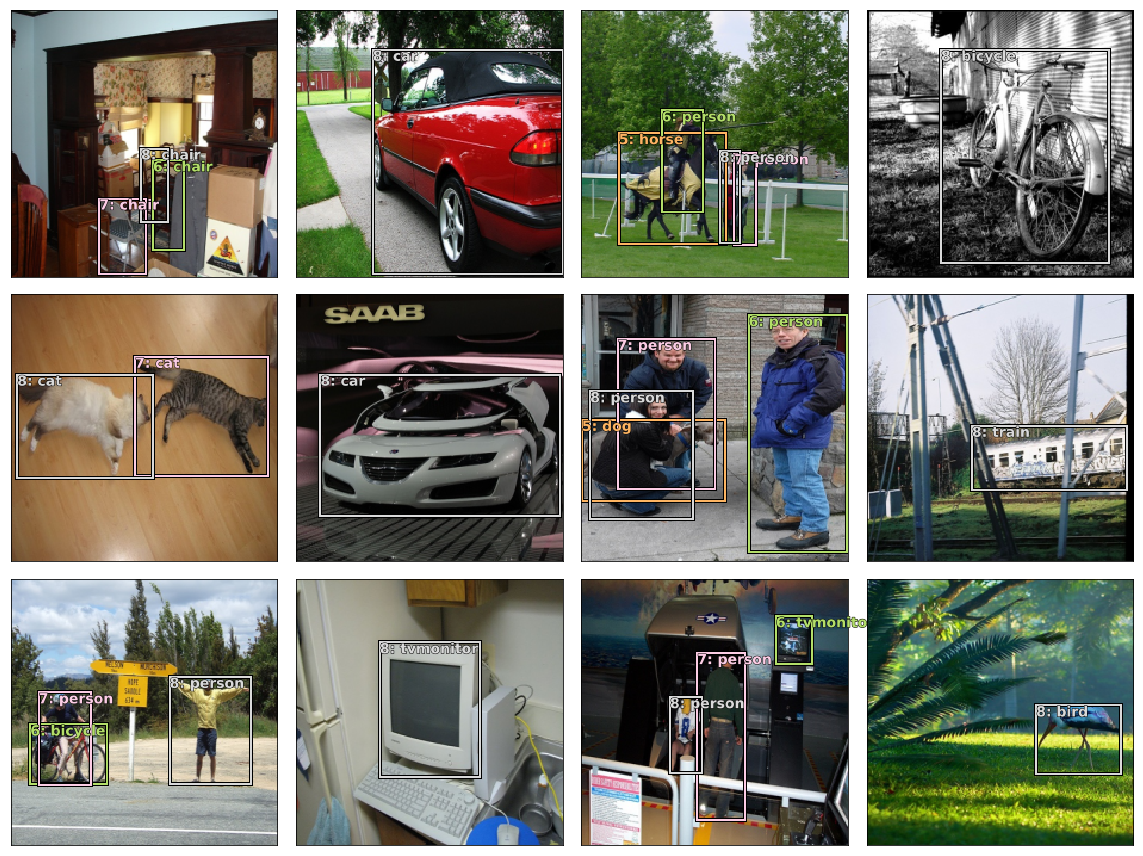

In [35]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, img_denorm(x[i]), y[0][i], target_classes[i])
plt.tight_layout()

## Architecture

In [36]:
from aliai.model import Model as resnetModelz

In [37]:

n_clas = len(idx2labels)+1
k=1
n_act = k*(4+n_clas)

In [38]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.drop(self.bn(self.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [39]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(idx2labels)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv2(x), self.k),
                flatten_conv(self.oconv1(x), self.k)]

In [37]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(self.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)
head_reg4 = SSD_Head(k, -3.)
modelz =resnetModelz(n_act,is_reg=True,custom_head=head_reg4).to(device)

In [40]:
from torch.autograd import Variable as V

In [41]:

def T(a,half=False):
    
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8,np.int16,np.int32,np.int64):
            return torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32,np.float64):
            return torch.FloatTensor(a)
    return a

In [40]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
con_anc = np.concatenate([anc_ctrs, anc_sizes],axis=1)

anchors = V(T(con_anc), requires_grad=False).float()
anchors = anchors.to(device)

In [41]:
grid_sizes = V(T(np.array([1/anc_grid])), requires_grad=False).unsqueeze(1);
grid_sizes = grid_sizes.to(device)

In [42]:
anchors

tensor([[ 0.1250,  0.1250,  0.2500,  0.2500],
        [ 0.1250,  0.3750,  0.2500,  0.2500],
        [ 0.1250,  0.6250,  0.2500,  0.2500],
        [ 0.1250,  0.8750,  0.2500,  0.2500],
        [ 0.3750,  0.1250,  0.2500,  0.2500],
        [ 0.3750,  0.3750,  0.2500,  0.2500],
        [ 0.3750,  0.6250,  0.2500,  0.2500],
        [ 0.3750,  0.8750,  0.2500,  0.2500],
        [ 0.6250,  0.1250,  0.2500,  0.2500],
        [ 0.6250,  0.3750,  0.2500,  0.2500],
        [ 0.6250,  0.6250,  0.2500,  0.2500],
        [ 0.6250,  0.8750,  0.2500,  0.2500],
        [ 0.8750,  0.1250,  0.2500,  0.2500],
        [ 0.8750,  0.3750,  0.2500,  0.2500],
        [ 0.8750,  0.6250,  0.2500,  0.2500],
        [ 0.8750,  0.8750,  0.2500,  0.2500]], device='cuda:0')

In [42]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [44]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[ 0.0000,  0.0000,  0.2500,  0.2500],
        [ 0.0000,  0.2500,  0.2500,  0.5000],
        [ 0.0000,  0.5000,  0.2500,  0.7500],
        [ 0.0000,  0.7500,  0.2500,  1.0000],
        [ 0.2500,  0.0000,  0.5000,  0.2500],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.5000,  0.5000,  0.7500],
        [ 0.2500,  0.7500,  0.5000,  1.0000],
        [ 0.5000,  0.0000,  0.7500,  0.2500],
        [ 0.5000,  0.2500,  0.7500,  0.5000],
        [ 0.5000,  0.5000,  0.7500,  0.7500],
        [ 0.5000,  0.7500,  0.7500,  1.0000],
        [ 0.7500,  0.0000,  1.0000,  0.2500],
        [ 0.7500,  0.2500,  1.0000,  0.5000],
        [ 0.7500,  0.5000,  1.0000,  0.7500],
        [ 0.7500,  0.7500,  1.0000,  1.0000]], device='cuda:0')

In [45]:
n_clas = len(idx2labels)+1
n_act = k*(4+n_clas)

In [43]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous()).to(device)#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        
        bce_loss = nn.functional.binary_cross_entropy_with_logits
        return bce_loss(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(idx2labels))

In [44]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [45]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(idx2labels)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_bb, b_c, bbox,clas in zip(*pred,*targ):
        
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [49]:

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,modelz.parameters()),lr=0.001)


In [55]:
def train(train_dataloader,modelz, ssd_loss,optimizer,epochs=5):
    
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        
        for i,(images,labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels[0] = labels[0].to(device)
            labels[1] = labels[1].to(device)
            
            output = modelz(images)
            
            loss = ssd_loss(output,labels)
            
            optimizer.zero_grad()
            
            loss.backward()
        
            optimizer.step()
        
            if (i+1) % 20 == 0:
                print(images.shape)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))
#train(train_dataloader, modelz,ssd_loss,optimizer,10)

In [ ]:
x,y = next(iter(test_dataloader))
x = x.to(device)
modelz.eval()
batch = modelz(x)
b_clas,b_bb = batchm

predicted_classes = b_clas.data.cpu().numpy()

In [ ]:
b_clas.size(),b_bb.size()

In [ ]:
idx=19
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=x[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

target_classes = clas.data.cpu().numpy()

In [ ]:
bbox.size(),clas.size()

In [46]:

def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, V): v=v.data
    if isinstance(v, torch.cuda.HalfTensor): v=v.float()
    return v.cpu().numpy()

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax,img_denorm(ima), to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

## More anchors!

### Create anchors

In [47]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [48]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [50]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(T(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])), requires_grad=False).unsqueeze(1)

grid_sizes = grid_sizes.to(device)
anchors = V(T(np.concatenate([anc_ctrs, anc_sizes], axis=1)), requires_grad=False).float()

anchors = anchors.to(device)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [51]:
anchors

tensor([[ 0.1250,  0.1250,  0.1750,  0.1750],
        [ 0.1250,  0.1250,  0.1750,  0.0875],
        [ 0.1250,  0.1250,  0.0875,  0.1750],
        [ 0.1250,  0.1250,  0.2500,  0.2500],
        [ 0.1250,  0.1250,  0.2500,  0.1250],
        [ 0.1250,  0.1250,  0.1250,  0.2500],
        [ 0.1250,  0.1250,  0.3250,  0.3250],
        [ 0.1250,  0.1250,  0.3250,  0.1625],
        [ 0.1250,  0.1250,  0.1625,  0.3250],
        [ 0.1250,  0.3750,  0.1750,  0.1750],
        [ 0.1250,  0.3750,  0.1750,  0.0875],
        [ 0.1250,  0.3750,  0.0875,  0.1750],
        [ 0.1250,  0.3750,  0.2500,  0.2500],
        [ 0.1250,  0.3750,  0.2500,  0.1250],
        [ 0.1250,  0.3750,  0.1250,  0.2500],
        [ 0.1250,  0.3750,  0.3250,  0.3250],
        [ 0.1250,  0.3750,  0.3250,  0.1625],
        [ 0.1250,  0.3750,  0.1625,  0.3250],
        [ 0.1250,  0.6250,  0.1750,  0.1750],
        [ 0.1250,  0.6250,  0.1750,  0.0875],
        [ 0.1250,  0.6250,  0.0875,  0.1750],
        [ 0.1250,  0.6250,  0.2500

In [52]:
x,y= next(iter(test_dataloader))
x = x.to(device)

### Model

In [60]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU()
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(self.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

multi_head_reg4 = SSD_MultiHead(k, -4.)
muti_head_modelz =resnetModelz(n_act,is_reg=True,custom_head=multi_head_reg4).to(device)

In [ ]:

optimizer_1 = torch.optim.Adam(filter(lambda p: p.requires_grad,muti_head_modelz.parameters()),lr=0.001)
train(train_dataloader, muti_head_modelz,ssd_loss,optimizer_1,12)

torch.Size([64, 3, 224, 224])
Epoch [1/12], Step [20/40], Loss: 150.8617
torch.Size([5, 3, 224, 224])
Epoch [1/12], Step [40/40], Loss: 10.4785
torch.Size([64, 3, 224, 224])
Epoch [2/12], Step [20/40], Loss: 121.3470
torch.Size([5, 3, 224, 224])
Epoch [2/12], Step [40/40], Loss: 8.9384
torch.Size([64, 3, 224, 224])
Epoch [3/12], Step [20/40], Loss: 105.5546
torch.Size([5, 3, 224, 224])
Epoch [3/12], Step [40/40], Loss: 4.0520
torch.Size([64, 3, 224, 224])
Epoch [4/12], Step [20/40], Loss: 94.1710
torch.Size([5, 3, 224, 224])
Epoch [4/12], Step [40/40], Loss: 7.9147
torch.Size([64, 3, 224, 224])
Epoch [5/12], Step [20/40], Loss: 98.2833
torch.Size([5, 3, 224, 224])
Epoch [5/12], Step [40/40], Loss: 9.7715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


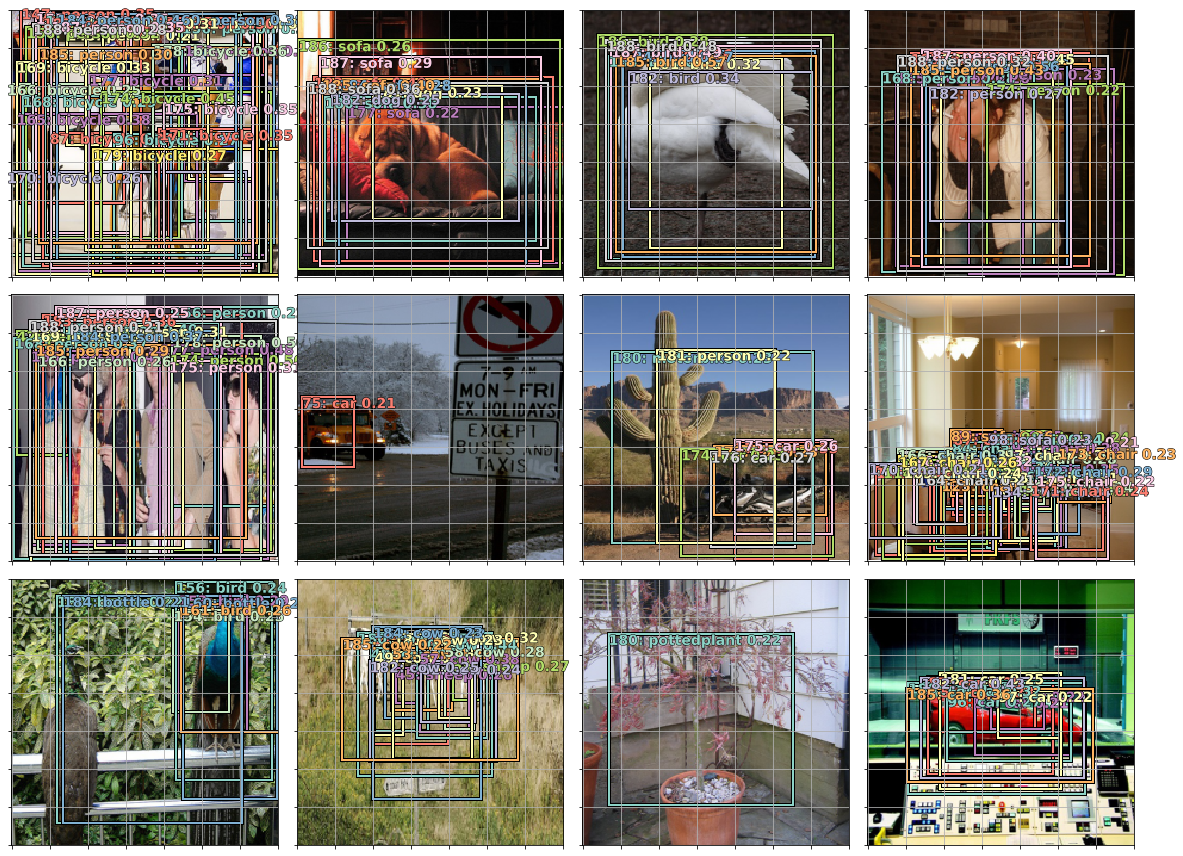

In [463]:
x,y = next(iter(test_dataloader))
x=x.to(device)00
b_clas,b_bb = muti_head_modelz(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima= x[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

## Focal loss

In [498]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [500]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [305]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, True)


 0.5598
 0.7922
 0.3095
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.5718
 0.7035
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.8714
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7268
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5163
 0.4763
 0.4033
 0.4986
 0.2990
 0.0887
 0.1046
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3789
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5153
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.6215
 0.5547
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.4246
 0.5208
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3436
 0.3257
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.9734
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3900
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7722
 0.5395
 0.6392
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.7618
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.4679
 0.8070
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.6597
 0.1274
[torch.cuda.FloatTensor of size 2 (GPU 0)]



Variable containing:
 10.9402
[torch.cuda.FloatTensor of size 1 (GPU 0)]

A Jupyter Widget

 19%|█▉        | 6/32 [00:05<00:24,  1.07it/s, loss=67.7]


Exception in thread Thread-228:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 72%|███████▏  | 23/32 [00:15<00:06,  1.44it/s, loss=nan] 


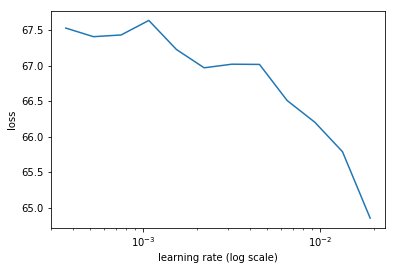

In [477]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [501]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      27.244542  32.936592 
    1      24.687115  22.024887                           
    2      22.251388  19.824711                           
    3      20.238359  18.530561                           
    4      18.613792  17.730865                           
    5      17.376519  17.323956                           
    6      16.33999   16.968851                           
    7      15.425277  16.894522                           
    8      14.683091  16.533207                           
    9      14.044275  16.332354                           



[16.332354]

In [502]:
learn.save('fl0')

In [472]:
learn.load('fl0')

In [503]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      13.991107  17.163681 
    1      14.275143  16.685173                           
    2      13.81701   16.067303                           
    3      13.172081  15.567028                           
    4      12.474847  15.480181                           
    5      11.774984  15.262911                           
    6      11.21864   15.10038                            
    7      10.711037  15.184849                           
    8      10.215424  14.942656                           
    9      9.871555   14.910997                           



[14.910997]

In [504]:
learn.save('drop4')

In [298]:
learn.load('drop4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


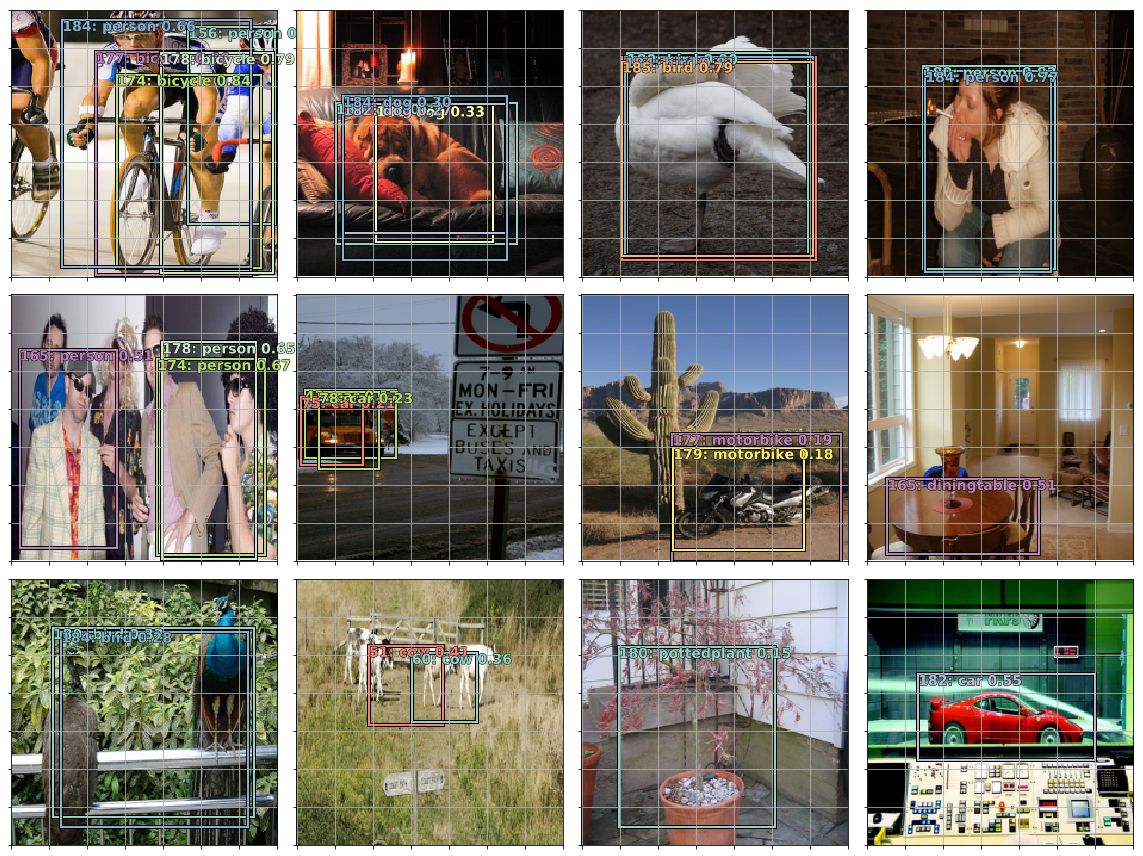

In [506]:
plot_results(0.75)

## NMS

In [492]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [493]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [494]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


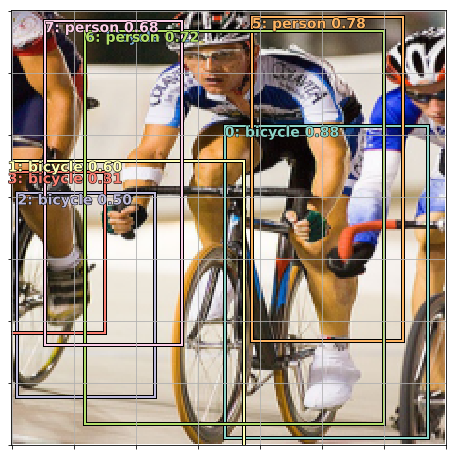

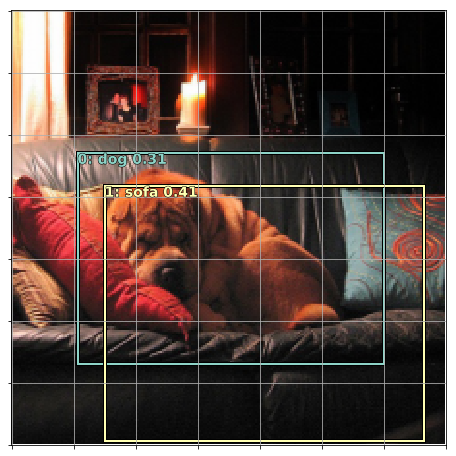

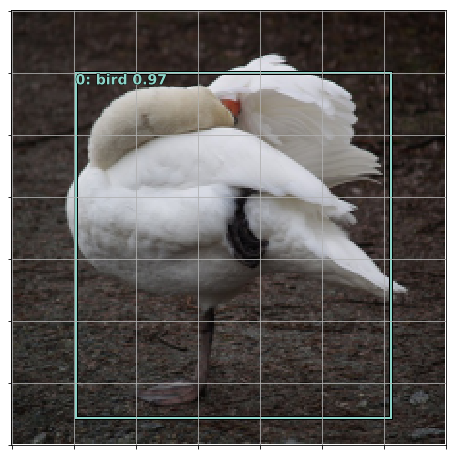

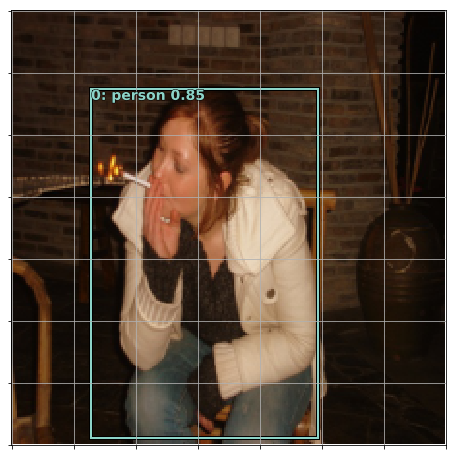

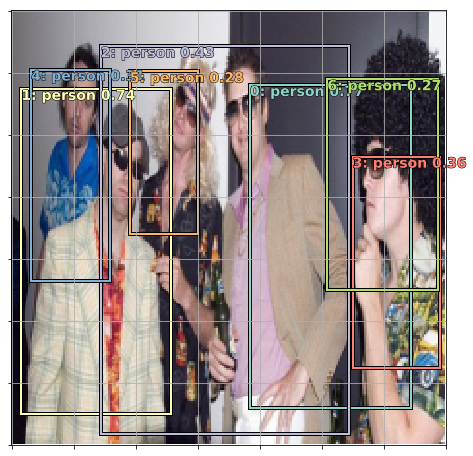

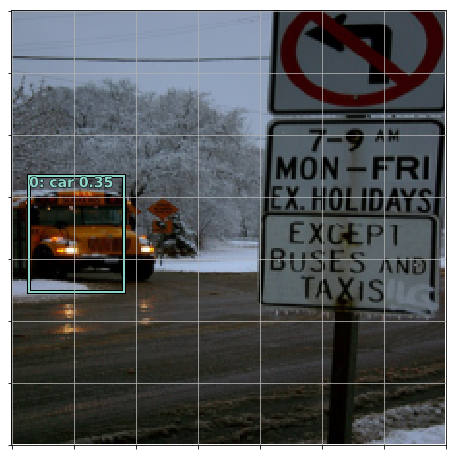

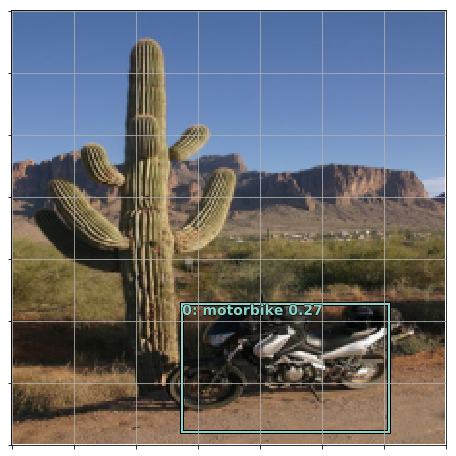

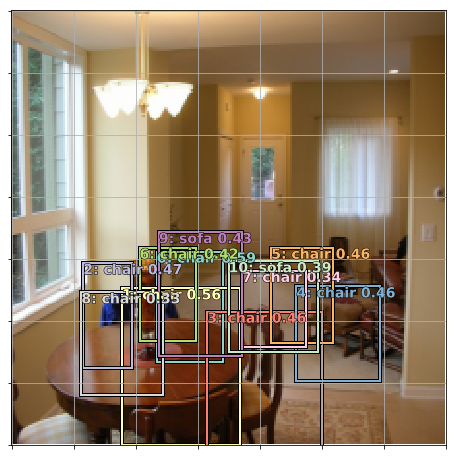

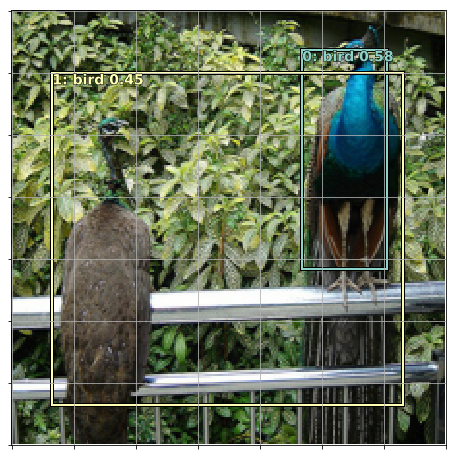

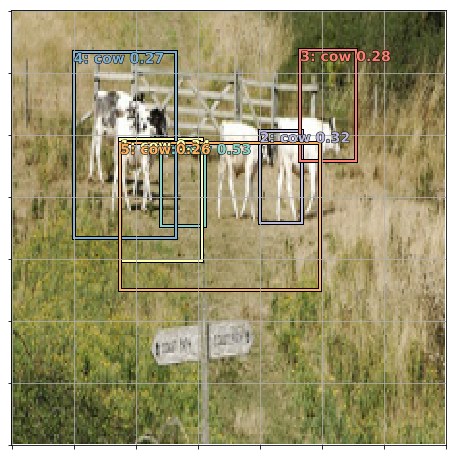

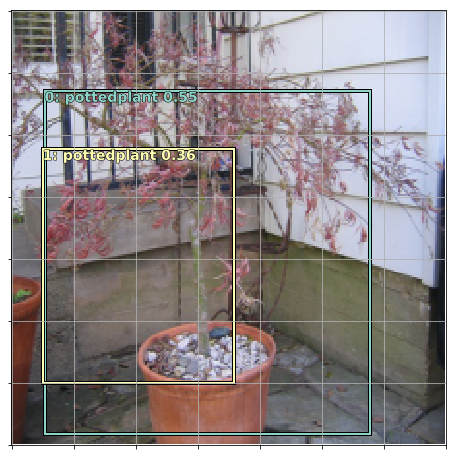

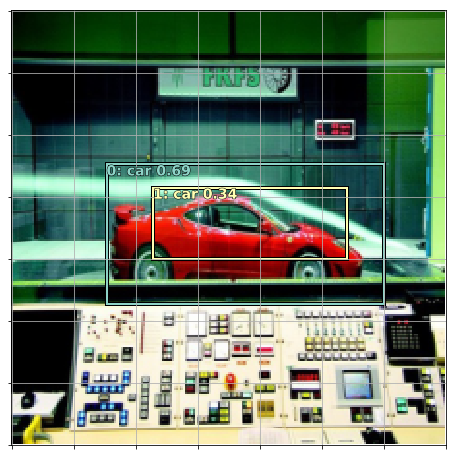

In [495]:
for i in range(12): show_nmf(i)

## End